In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import signal
from scipy import stats
from scipy import linalg
import time

import sys
sys.path.insert(0, '..')
import specsens as ss

   infs left at  0.00%
 60.86s left at  0.33%
 62.85s left at  0.67%
 62.60s left at  1.00%
 61.98s left at  1.33%
 62.92s left at  1.67%
 62.04s left at  2.00%
 61.62s left at  2.33%
 63.50s left at  2.67%
 60.95s left at  3.00%
 60.25s left at  3.33%
 59.42s left at  3.67%
 59.37s left at  4.00%
 65.54s left at  4.33%
 65.66s left at  4.67%
 58.49s left at  5.00%
 58.18s left at  5.33%
 58.42s left at  5.67%
 59.18s left at  6.00%
 57.54s left at  6.33%
 57.59s left at  6.67%
 57.33s left at  7.00%
 57.38s left at  7.33%
 57.73s left at  7.67%
 57.35s left at  8.00%
 56.52s left at  8.33%
 58.07s left at  8.67%
 56.53s left at  9.00%
 56.61s left at  9.33%
 56.37s left at  9.67%
 55.59s left at 10.00%
 55.73s left at 10.33%
 56.63s left at 10.67%
 56.66s left at 11.00%
 54.99s left at 11.33%
 54.34s left at 11.67%
 54.19s left at 12.00%
 55.50s left at 12.33%
 53.45s left at 12.67%
 54.15s left at 13.00%
 53.42s left at 13.33%
 53.01s left at 13.67%
 54.67s left at 14.00%
 52.47s lef

/home/fabian/.local/lib/python3.6/site-packages/ipykernel_launcher.py:114: RuntimeWarning: invalid value encountered in double_scalars


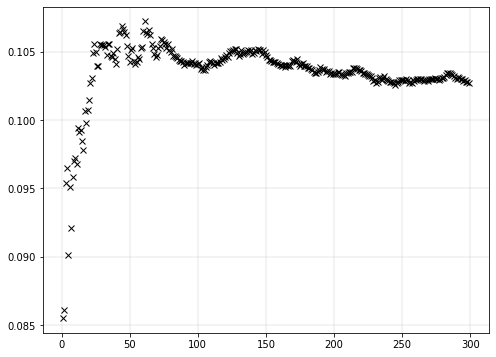

Theory     pfa 0.1
Simulation pfa 0.10268164025253872
Theory     pd  0.26052235041796956
Simulation pd  0.2595848716991606


In [16]:
n_bands = 4
n_fft = 1024
n_stats = 1024 // n_bands
band_to_detect = 2


class MonteCarloSim():
    def __init__(self, gens, itrs):
        self.gens = gens  # Number of generations
        self.itrs = itrs  # NUmber of iterations per generation
        self.reset()

    def reset(self):
        self.pfas = list()  # Probability of false alarm list
        self.pds = list()  # Probability of detection list
        self.time = None

    def run(self,
            signal_strength=0.,
            noise_strength=0.,
            sample_freq=1e6,
            length=1.,
            pre_pfa=0.1):

        self.reset()
        thr = ss.chi2_stats.get_thr(
            noise_power=ss.util.dB_to_factor_power(noise_strength),
            pfa=pre_pfa,
            #             n=ss.util.get_signal_length(f_sample=sample_freq, t_sec=length))
            n=n_stats)
        length = ss.util.sample_time(f_sample=sample_freq, num_samples=n_fft)

        for i in range(self.gens):
            wm = ss.WirelessMicrophone(f_sample=sample_freq, t_sec=length)
            wgn = ss.WhiteGaussianNoise(f_sample=sample_freq, t_sec=length)

            correct_hit = 0
            false_hit = 0
            correct_miss = 0
            false_miss = 0
            times_signal_present = 0

            # As soon as we introduce noise uncertainty, the detector performs badly
            # This is expected, as energy detectors cant handle noise uncertainty
            #             noise_uncertainty = np.random.uniform(-1., 1.)
            noise_uncertainty = 0.

            for j in range(self.itrs):
                sig = wm.get_soft(f_center=1e5, dB=signal_strength)
                noise = wgn.get_signal(dB=noise_strength + noise_uncertainty)

                sig_present = bool(np.random.randint(2))
                if sig_present:
                    both = sig + noise
                    times_signal_present += 1
                else:
                    both = noise

                # Classical energy detector
                # eng = ss.EnergyDetector.get(both)

                # Mutliband stft based energy detector
                sft = ss.Stft(
                    n=n_fft,
                    window='box')  # currently only working with box window
                f, psd = sft.stft(sig=both,
                                  f_sample=sample_freq,
                                  normalized=False,
                                  dB=False)
                edf = ss.FreqEnergyDetector(num_bands=n_bands,
                                            f_sample=1e6,
                                            fft_len=n_fft,
                                            freqs=f)
                eng = edf.detect(psd)[band_to_detect]

                # Threshold
                sig_detected = eng > thr

                if sig_present and sig_detected:
                    correct_hit += 1
                elif sig_present and not sig_detected:
                    false_miss += 1
                elif not sig_present and sig_detected:
                    false_hit += 1
                else:
                    correct_miss += 1

            pfa_tmp = false_hit / (self.itrs - times_signal_present)
            pd_tmp = correct_hit / times_signal_present
            self.pfas.append(pfa_tmp)
            self.pds.append(pd_tmp)
            rem, per = self.runtime_stats(self.gens, i)
            print('%6.2fs left at %5.2f%%' % (rem, per))

        pfa = np.sum(self.pfas) / self.gens
        pd = np.sum(self.pds) / self.gens
        return pfa, pd

    def runtime_stats(self, total_itr, current_itr):
        if self.time is None:
            self.time = time.time()
            return float('inf'), 0.0
        delta_time = time.time() - self.time
        self.time = time.time()
        remaining_itr = total_itr - current_itr
        remaining_time = delta_time * remaining_itr
        percent_done = current_itr / total_itr * 100.0
        return remaining_time, percent_done

    def print_convergence(self):
        plt.figure(figsize=(8, 6))
        plt.grid(linewidth=0.3)
        for i in range(self.gens):
            inter = np.sum(self.pfas[0:i]) / i
            plt.plot(i, inter, 'kx')
        plt.show()


signal_strength = 0.
noise_strength = 20.
pre_pfa = 0.1
sim = MonteCarloSim(300, 300)
pfa, pd = sim.run(signal_strength=0.,
                  noise_strength=20.,
                  sample_freq=1e6,
                  length=0.002,
                  pre_pfa=pre_pfa)

sim.print_convergence()

print(f'Theory     pfa {0.1}')
print(f'Simulation pfa {pfa}')

fac_sig = ss.util.dB_to_factor_power(signal_strength)
fac_noise = ss.util.dB_to_factor_power(noise_strength) / n_bands
theo_thr = ss.chi2_stats.get_thr(fac_noise, pre_pfa, n_stats)
pd_theo = ss.chi2_stats.get_pd(fac_noise,
                               fac_sig,
                               theo_thr, n_stats)
print(f'Theory     pd  {pd_theo}')
print(f'Simulation pd  {pd}')

In [19]:
ss.chi2_stats.get_thr(
            noise_power=ss.util.dB_to_factor_power(noise_strength),
            pfa=pre_pfa,
            #             n=ss.util.get_signal_length(f_sample=sample_freq, t_sec=length))
            n=n_stats)
theo_thr

6917.675308306647